#Using a GPU

In [ ]:
# Are we using a GPU?
!nvidia-smi

Thu May 12 16:58:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Downloading and becoming one with the data

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-12 16:59:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.217.1.208, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2022-05-12 16:59:17 (177 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

# Creating data loaders (preparing the data)

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


#Setting up callbacks (things to run whilst our model trains)


In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using TensorFlow Hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220512-170255
Epoch 1/5
24/24 [==============================] - 38s 854ms/step - loss: 2.0652 - accuracy: 0.3187 - val_loss: 1.2647 - val_accuracy: 0.5916
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9517 - accuracy: 0.7347 - val_loss: 0.8725 - val_accuracy: 0.7200
Epoch 3/5
24/24 [==============================] - 16s 669ms/step - loss: 0.6404 - accuracy: 0.8080 - val_loss: 0.7720 - val_accuracy: 0.7440
Epoch 4/5
24/24 [==============================] - 15s 665ms/step - loss: 0.4925 - accuracy: 0.8573 - val_loss: 0.7208 - val_accuracy: 0.7652
Epoch 5/5
24/24 [==============================] - 16s 666ms/step - loss: 0.3973 - accuracy: 0.9120 - val_loss: 0.6851 - val_accuracy: 0.7752


In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

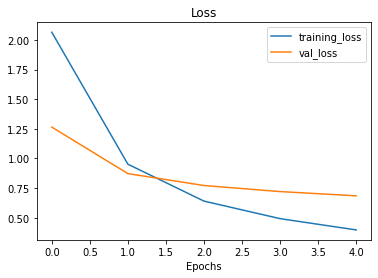

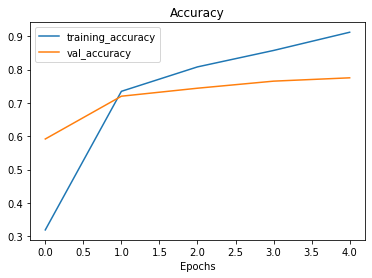

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220512-170501
Epoch 1/5
24/24 [==============================] - 25s 701ms/step - loss: 1.8767 - accuracy: 0.4227 - val_loss: 1.3000 - val_accuracy: 0.7268
Epoch 2/5
24/24 [==============================] - 15s 640ms/step - loss: 1.0680 - accuracy: 0.7893 - val_loss: 0.8637 - val_accuracy: 0.8148
Epoch 3/5
24/24 [==============================] - 15s 635ms/step - loss: 0.7655 - accuracy: 0.8373 - val_loss: 0.6945 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 15s 636ms/step - loss: 0.6157 - accuracy: 0.8627 - val_loss: 0.6061 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 15s 636ms/step - loss: 0.5172 - accuracy: 0.8867 - val_loss: 0.5515 - val_accuracy: 0.8636


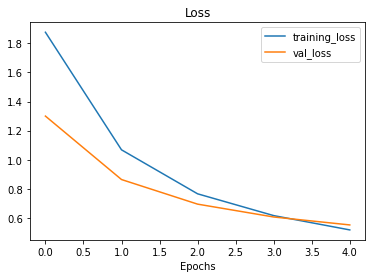

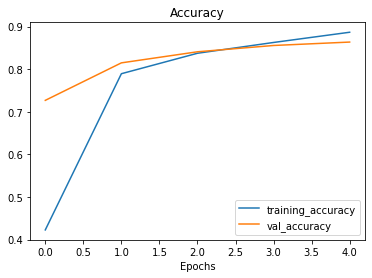

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

In [ ]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/nMkWb8t7TpW7CBBDanipag/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   nMkWb8t7TpW7CBBDanipag
	Created              2022-05-12 18:04:39 (3 minutes ago)
	Updated              2022-05-12 18:04:41 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA